In [1]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import io
import gdown

from google.colab import drive
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from google.colab import files
from PIL import Image
import os

%matplotlib inline

torch.manual_seed(128)

In [3]:
#Pastiin pake GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Definisi Kelas
class_names = ['andrao', 'asiatica', 'auranti', 'barca', 'maru', 'stewartii']

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Set input and output directories
# input_dir = '/content/drive/MyDrive/datasheet'
# output_dir = '/content/drive/MyDrive/datasheet_jpg'

In [ ]:
# # Loop through all image files in the input directory
# for filename in os.listdir(input_dir):
#     if filename.endswith('.png') or filename.endswith('.jpg'):
#         # Open the image file
#         img_path = os.path.join(input_dir, filename)
#         img = Image.open(img_path)

#         # Create output filename by replacing extension with .jpg
#         output_filename = os.path.splitext(filename)[0] + '.jpg'
#         output_path = os.path.join(output_dir, output_filename)

#         # Convert the image to JPEG format and save to output file
#         img.save(output_path, 'JPEG')

In [6]:
# Download Datasheet
url = "https://drive.google.com/uc?id=1P1LRTg_UZi8Ns56F8pkB8B0hAEiIwYK6"
output = "datasheet.zip"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1P1LRTg_UZi8Ns56F8pkB8B0hAEiIwYK6
To: /content/datasheet.zip
100%|██████████| 969M/969M [00:04<00:00, 204MB/s]


'datasheet.zip'

In [7]:
#ekstrak file
!unzip "/content/datasheet.zip" -d "/content/"

Archive:  /content/datasheet.zip
  inflating: /content/datasheet/barca/barca_75.png  
  inflating: /content/datasheet/barca/barca_82.png  
  inflating: /content/datasheet/barca/barca_85.png  
  inflating: /content/datasheet/barca/barca_97.png  
  inflating: /content/datasheet/barca/barca_31.png  
  inflating: /content/datasheet/barca/barca_81.png  
  inflating: /content/datasheet/barca/barca_96.png  
  inflating: /content/datasheet/barca/barca_80.png  
  inflating: /content/datasheet/barca/barca_77.png  
  inflating: /content/datasheet/barca/barca_87.png  
  inflating: /content/datasheet/barca/barca_89.png  
  inflating: /content/datasheet/barca/barca_11.png  
  inflating: /content/datasheet/barca/barca_79.png  
  inflating: /content/datasheet/barca/barca_95.png  
  inflating: /content/datasheet/barca/barca_93.png  
  inflating: /content/datasheet/barca/barca_36.png  
  inflating: /content/datasheet/barca/barca_72.png  
  inflating: /content/datasheet/barca/barca_73.png  
  inflating: 

In [8]:
#apply pada dataset yg dipakai
dataset = torchvision.datasets.ImageFolder('/content/datasheet', transform=transform)

In [9]:
#split data train dan val, buat loader
class_indices = {}
for i, (image, label) in enumerate(dataset):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

train_indices = []
val_indices = []

for label in class_indices.keys():
    indices = class_indices[label]
    num_samples = len(indices)
    split = int(0.75 * num_samples)  #80:20 setiap kelas
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)

batch_size = 52
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

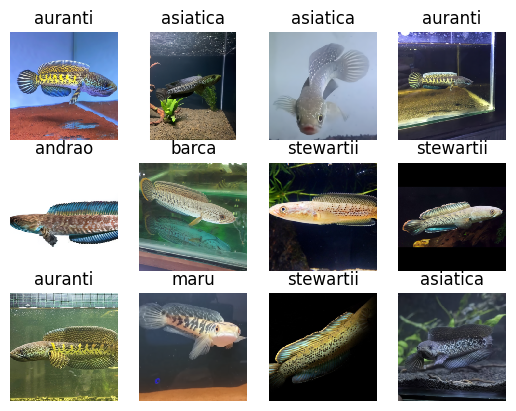

In [10]:
#cek gambar data
images, labels = next(iter(train_loader))

fig = plt.figure()
#plot gambar
for i in range(12):
    img = np.transpose(images[i-1], (1, 2, 0))
    # denormalized_img = (img * 0.5) + 0.5
    plt.subplot(3,4,i+1)
    plt.imshow(img, interpolation='none')
    plt.title(class_names[labels[i-1]])
    plt.axis('off')

plt.show()

In [11]:
#pakai model Alex yg diatur jumlah layernya
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, num_blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ResNet().to(device)

In [12]:
#atur loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [13]:
#define jumlah epoch, sama variabel kosongan untuk diisi nilai
n_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    train_loss = 0.0
    train_correct = 0
    val_loss = 0.0
    val_correct = 0
    
    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) #pake CUDA
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device) #pake CUDA
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            val_correct += (predicted == target).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    # Print the results for this epoch
    print("Epoch {}: loss {:.4f}, accuracy {:.4f}, val_loss {:.4f}, val_accuracy {:.4f}".format(
        epoch+1, train_loss, train_acc, val_loss, val_acc))

Epoch 1: loss 2.1590, accuracy 29.3333, val_loss 2.2774, val_accuracy 16.6667
Epoch 2: loss 1.8834, accuracy 36.6667, val_loss 2.2017, val_accuracy 16.6667
Epoch 3: loss 1.6479, accuracy 40.2222, val_loss 2.1912, val_accuracy 16.6667
Epoch 4: loss 1.5007, accuracy 45.3333, val_loss 2.2235, val_accuracy 25.3333
Epoch 5: loss 1.4077, accuracy 51.5556, val_loss 1.8536, val_accuracy 28.0000
Epoch 6: loss 1.3168, accuracy 53.5556, val_loss 1.5086, val_accuracy 40.0000
Epoch 7: loss 1.2622, accuracy 58.0000, val_loss 1.5503, val_accuracy 40.6667
Epoch 8: loss 1.1913, accuracy 59.3333, val_loss 1.2520, val_accuracy 54.0000
Epoch 9: loss 1.1019, accuracy 64.8889, val_loss 1.3789, val_accuracy 52.6667
Epoch 10: loss 1.0483, accuracy 63.7778, val_loss 1.3093, val_accuracy 50.0000
Epoch 11: loss 0.9884, accuracy 67.7778, val_loss 1.2544, val_accuracy 53.3333
Epoch 12: loss 0.9202, accuracy 71.1111, val_loss 2.2285, val_accuracy 41.3333
Epoch 13: loss 0.8959, accuracy 70.0000, val_loss 1.2382, val

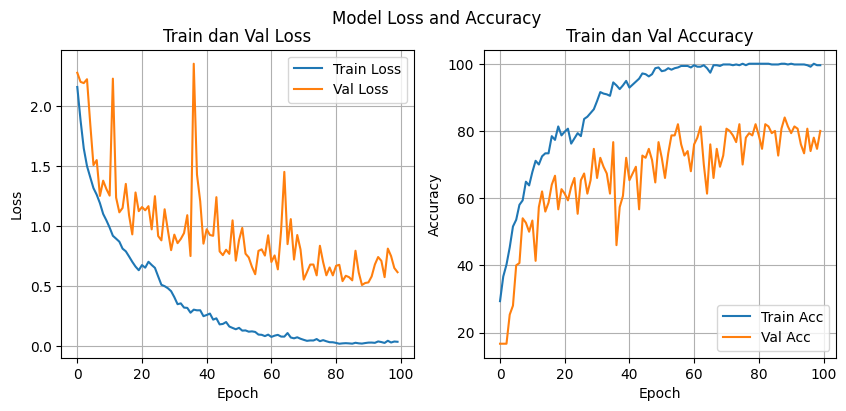

In [14]:
#bikin plot dari hasil training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train dan Val Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc')
ax2.plot(val_accuracies, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train dan Val Accuracy')
ax2.legend()
ax2.grid(True)

fig.suptitle('Model Loss and Accuracy')
plt.show()

In [15]:
#simpen model
torch.save(model.state_dict(), 'resnet_modelv3.pt')

In [16]:
#load model
model.load_state_dict(torch.load('resnet_modelv3.pt'))

<All keys matched successfully>

Saving AN1.jpg to AN1.jpg
AN1.jpg
andrao


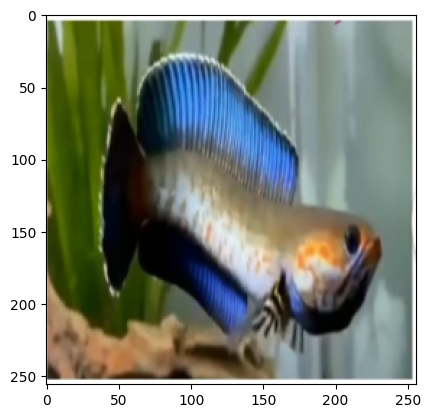

In [17]:
#pengujian model yg dilatih
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = torchvision.transforms.functional.resize(
        torchvision.transforms.functional.to_pil_image(
            np.array(Image.open(io.BytesIO(uploaded[fn])))
        ),
        (256, 256)
    )

    imgplot = plt.imshow(img)
    x = torchvision.transforms.functional.to_tensor(img)
    x = x.unsqueeze(0)
    x = x.to(device)
    
    with torch.no_grad():
        outputs = model(x)
    
    _, preds = torch.max(outputs, 1)
    
    print(fn)
    if preds.item() == 0:
        print('andrao')
    elif preds.item() == 1:
        print('asiatica')
    elif preds.item() == 2:
        print('auranti')
    elif preds.item() == 3:
        print('barca')          
    elif preds.item() == 4:
        print('maru')
    elif preds.item() == 5:
        print('stewartii')
    else:
        print('not detected')
